In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# The following list is the raw tick data for sim length
# 1 message is sent around the network, no failures
# To get seconds, divide each number by 1x10^6
sim_lengths = [11490430, 10003359, 13931034, 9337192, 11873662, 
              20700903, 70734350, 9723444, 36370158, 20700903]
print('Median:', np.median(sim_lengths), 'Mean:', np.mean(sim_lengths))
print('Std Dev:', np.std(sim_lengths))

('Median:', 12902348.0, 'Mean:', 21486543.5)
('Std Dev:', 18208127.76003491)


In [3]:
print(np.median(sim_lengths)/1000)

12902.348


In [6]:
import os
import re
import pickle
import pandas as pd
import numpy as np

from collections import namedtuple
from functools import reduce
from pathlib2 import Path


exp_path = Path(os.getcwd(), 'experiments')
exp_re = re.compile(r'(?P<n>\d+)-(?P<t>\w+)-(?P<k>\d+)-(?P<imin>\d+)-(?P<imax>\d+)-(?P<d>\d+)-run(?P<r>\d)')
experiments = filter(lambda x: os.path.isdir(str(Path(exp_path, x))), os.listdir(str(exp_path)))
experiments = filter(lambda x: 'control' not in x, experiments)


def parse_logfile(path):
    f = pd.read_csv(str(path), names=['time','msg'], header=None, delimiter=';')
    tx_count = 0
    token_val = -1
    
    for index, row in f.iterrows():
        text = row['msg']
        
        if 'Trickle TX' in text:
            tx_count += 1
        elif 'Current token' in text:
            token_val = int(re.match(r'.*Current\ token:\ (?P<n>\d+)', text).group('n'))
            
    return tx_count, token_val


Experiment = namedtuple('Experiment', ['d', 'k', 'imin', 'n', 't', 'imax'])
exp_dict = {}


for exp in experiments:
    exp_dir = Path(exp_path, exp)
    params = exp_re.match(exp).groupdict()
    params.pop('r', -1)
    
    experiment = Experiment(**params)
    
    files = filter(lambda x: "run" in x, os.listdir(str(exp_dir)))
    filename_re = re.compile(r'.*\_(?P<id>\d+)\.txt')
    
    experiment_dict = {}
    
    for f in files:
        node_id = filename_re.match(f).group('id')
        
        experiment_dict[node_id] = parse_logfile(Path(exp_dir, f))
    
    total_tx = 0
    total_has_token = 0
    for t in experiment_dict.values():
        total_tx += t[0]
        
        if t[1] == 1:
            total_has_token += 1
    
    if exp_dict.get(experiment):
        exp_dict[experiment].append((total_tx, (total_has_token / 49.0) * 100))
    else:
        exp_dict[experiment] = [(total_tx, (total_has_token / 49.0) * 100)]
        
        
with open('experiment_data.pickle', 'wb') as handle:
    pickle.dump(exp_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

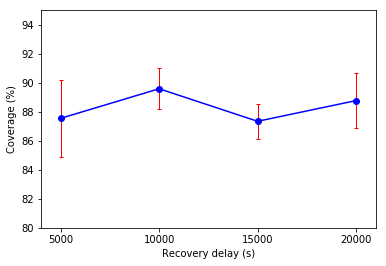

In [55]:
def filter_experiments(experiments, mask):
    # Mask is a namedtuple that has None for fields that are to be ignored
    mask_set = set(filter(lambda x: x[1], mask._asdict().items()))
    return filter(lambda x: mask_set <= set(x._asdict().items()), experiments)


coverage_delay_loc = filter_experiments(exp_dict.keys(), Experiment(d='', k='', imin='', n='11', t='location', imax=''))
coverage_delay_loc = sorted(coverage_delay_loc, key=lambda x: int(x.d))

d = []
cov = []
msg = []
cov_std = []
msg_std = []

for exp in coverage_delay_loc:
    msgs, coverage = [list(t) for t in zip(*exp_dict[exp])]
    
    d.append(int(exp.d))
    cov.append(np.mean(coverage))
    cov_std.append(np.std(coverage))
    msg.append(np.mean(msgs))
    msg_std.append(np.std(msgs))
    
# print(cov_std)
    
plt.errorbar(d, cov, cov_std, ecolor='r', elinewidth=1, capsize=2, marker='o', color='b')
plt.xlim(4000, 21000)
plt.xticks(d)
plt.ylim(80, 95)
plt.ylabel('Coverage (%)')
plt.xlabel('Recovery delay (s)')
plt.show()
#     print(np.mean(msgs), np.mean(coverage), np.std(coverage), 'd=' + exp.d)

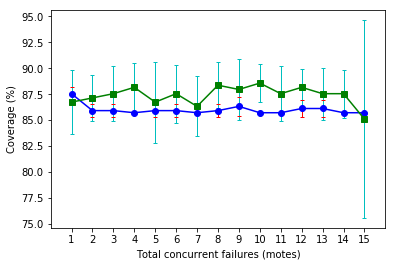

In [49]:
coverage_mote_fails = filter_experiments(exp_dict.keys(), Experiment(d='5000', k='', imin='', n='', t='random', imax=''))
coverage_mote_fails_loc = filter_experiments(exp_dict.keys(), Experiment(d='5000', k='', imin='', n='', t='location', imax=''))
coverage_mote_fails = sorted(coverage_mote_fails, key=lambda x: int(x.n))
coverage_mote_fails_loc = sorted(coverage_mote_fails_loc, key=lambda x: int(x.n))

n = []
cov2 = []
cov2_std = []

cov2loc = []
cov2loc_std = []

for exp in coverage_mote_fails:
    _, coverage = [list(t) for t in zip(*exp_dict[exp])]
    
    n.append(int(exp.n))
    cov2.append(np.mean(coverage))
    cov2_std.append(np.std(coverage))
    
    
for exp in coverage_mote_fails_loc:\
    _, coverage = [list(t) for t in zip(*exp_dict[exp])]
    
    cov2loc.append(np.mean(coverage))
    cov2loc_std.append(np.std(coverage))
    
plt.errorbar(n, cov2, cov2_std, ecolor='r', elinewidth=1, capsize=2, marker='o', color='b')
plt.errorbar(n, cov2loc, cov2loc_std, ecolor='c', elinewidth=1, capsize=2, marker='s', color='g')
plt.xlim(0, 16)
plt.xticks(n)
plt.ylabel('Coverage (%)')
plt.xlabel('Total concurrent failures (motes)')
plt.show()

In [11]:
import os
import re
import pickle
import pandas as pd
import numpy as np

from collections import namedtuple, defaultdict
from functools import reduce
from pathlib import Path

import matplotlib.pyplot as plt

%matplotlib inline

Experiment = namedtuple('Experiment', ['d', 'k', 'imin', 'n', 't', 'imax'])

with open('experiment_data.pickle', 'rb') as handle:
    pickled_data = pickle.load(handle)
    
def filter_experiments(experiments, mask):
    # Mask is a namedtuple that has None for fields that are to be ignored
    mask_set = set(filter(lambda x: x[1], mask._asdict().items()))
    return filter(lambda x: mask_set <= set(x._asdict().items()), experiments)

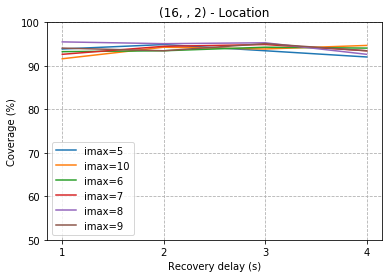

In [32]:
cov_dict = defaultdict(list)
cov_exp_list = list(filter_experiments(pickled_data.keys(), 
                                       Experiment(d='', k='2', imin='16', n='8', t='location', imax='')))

x_axis = set()

for exp in cov_exp_list:
    imax = int(exp.imax)
    cov_dict[imax].append(exp)
    x_axis.add(int(exp.d))
    
for key in cov_dict.keys():
    items = cov_dict[key]
    cov_dict[key] = sorted(items, key=lambda x: int(x.d))
    
x_axis = sorted(x_axis)
coverage = defaultdict(list)

# Coverage dict is a ordered-list of tuples (ordered by recovery delay)
# each tuple is (value, std dev)
for key, items in cov_dict.items():
    for exp in items:
        data = list(map(lambda x: x[1], pickled_data[exp]))
        coverage[key].append((np.mean(data), np.std(data)))
        
for run, data in coverage.items():
    dat = list(map(lambda x: x[0], data))
    err = list(map(lambda x: x[1], data))
    
    plt.plot(x_axis, dat)
    
plt.xticks(x_axis)
plt.ylabel('Coverage (%)')
plt.xlabel('Recovery delay (s)')
plt.title('Location failure mode ')
plt.grid(linestyle='--')
plt.ylim(50, 100)
plt.legend(list(map(lambda x: f'imax={x}', coverage.keys())))
plt.savefig(format='png', fname='coverage-recovery.png', dpi=300)

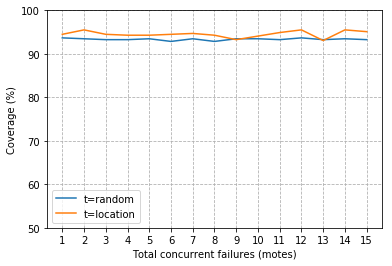

In [29]:
cov_loc_dict = defaultdict(list)
cov_loc_exp_list = list(filter_experiments(pickled_data.keys(),
                                          Experiment(d='2', k='2', imin='16', n='', t='', imax='10')))

cov_loc_exp_dict = defaultdict(list)
x = set()
for exp in cov_loc_exp_list:
    cov_loc_exp_dict[exp.t].append(exp)
    x.add(int(exp.n))
    
x = sorted(x)
for t, items in cov_loc_exp_dict.items():
    cov_loc_exp_dict[t] = list(map(lambda x: (
        np.mean(list(map(lambda y: y[1], pickled_data[x]))),
        np.std(list(map(lambda y: y[1], pickled_data[x]))),
    ), sorted(items, key=lambda x: int(x.n))))
    
for run, data in cov_loc_exp_dict.items():
    dat = list(map(lambda x: x[0], data))
    err = list(map(lambda x: x[1], data))
    
    plt.plot(x, dat)
    
plt.xticks(x)
plt.ylabel('Coverage (%)')
plt.xlabel('Total concurrent failures (motes)')
plt.ylim(50, 100)
plt.legend(list(map(lambda x: f't={x}', cov_loc_exp_dict.keys())))
plt.grid(linestyle='--')
plt.savefig(format='png', fname='coverage-concurrent.png', dpi=300)

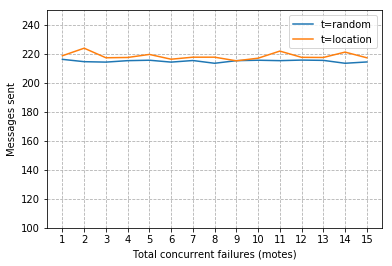

In [30]:
msg_loc_exp_dict = defaultdict(list)
msg_x = set()

for exp in cov_loc_exp_list:
    msg_loc_exp_dict[exp.t].append(exp)
    msg_x.add(int(exp.n))
    
msg_x = sorted(msg_x)
for t, items in msg_loc_exp_dict.items():
    msg_loc_exp_dict[t] = list(map(lambda x: (
        np.mean(list(map(lambda y: y[0], pickled_data[x]))),
        np.std(list(map(lambda y: y[0], pickled_data[x]))),
    ), sorted(items, key=lambda x: int(x.n))))
    
for run, data in msg_loc_exp_dict.items():
    dat = list(map(lambda x: x[0], data))
    err = list(map(lambda x: x[1], data))
    
    plt.plot(x, dat)
    
plt.xticks(x)
plt.ylabel('Messages sent')
plt.xlabel('Total concurrent failures (motes)')
plt.ylim(100, 250)
plt.legend(list(map(lambda x: f't={x}', cov_loc_exp_dict.keys())))
plt.grid(linestyle='--')
plt.savefig(format='png', fname='messages-concurrent.png', dpi=300)

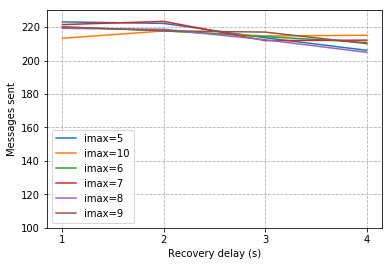

In [31]:
msg_dict = defaultdict(list)
msg_x_axis = set()

for exp in cov_exp_list:
    imax = int(exp.imax)
    msg_dict[imax].append(exp)
    msg_x_axis.add(int(exp.d))
    
for key in cov_dict.keys():
    items = msg_dict[key]
    msg_dict[key] = sorted(items, key=lambda x: int(x.d))
    
msg_x_axis = sorted(msg_x_axis)
msgs = defaultdict(list)

# Coverage dict is a ordered-list of tuples (ordered by recovery delay)
# each tuple is (value, std dev)
for key, items in cov_dict.items():
    for exp in items:
        data = list(map(lambda x: x[0], pickled_data[exp]))
        msgs[key].append((np.mean(data), np.std(data)))
        
for run, data in msgs.items():
    dat = list(map(lambda x: x[0], data))
    err = list(map(lambda x: x[1], data))
    
    plt.plot(x_axis, dat)
    
plt.xticks(x_axis)
plt.ylabel('Messages sent')
plt.xlabel('Recovery delay (s)')
plt.grid(linestyle='--')
plt.ylim(100, 230)
plt.legend(list(map(lambda x: f'imax={x}', coverage.keys())))
plt.savefig(format='png', fname='messages-recovery.png', dpi=300)